# Titanic survival prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

np.random.seed(12345)
pd.set_option('display.max_columns', None)

#### Preparing the data

In [2]:
train_full = pd.read_csv("data/train.csv", index_col='PassengerId')
test_full = pd.read_csv("data/test.csv", index_col='PassengerId')

In [3]:
train_full.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_full.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_full['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Due to considerable sexes imbalance and relatively low amounts of data, we will use stratified split to divide the set into training data and validation data.

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)

for train_idx, valid_idx in split.split(train_full, train_full['Sex']):
    # One iteration though
    X_train_raw = train_full.iloc[train_idx].copy()
    X_valid_raw = train_full.iloc[valid_idx].copy()

y_train = X_train_raw['Survived']
y_valid = X_valid_raw['Survived']

X_train_raw.drop(['Survived'], axis=1, inplace=True)
X_valid_raw.drop(['Survived'], axis=1, inplace=True)

X_test_raw = test_full.copy()

for df in [X_train_raw, X_valid_raw, X_test_raw]:
    df.reset_index(inplace=True)
    df.drop('PassengerId', axis=1, inplace=True)

y_train = y_train.reset_index().drop('PassengerId', axis=1)['Survived']
y_valid = y_valid.reset_index().drop('PassengerId', axis=1)['Survived']

In [7]:
X_train_raw

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,S
1,3,"Webber, Mr. James",male,NaN,0,0,SOTON/OQ 3101316,8.0500,NaN,S
2,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S
3,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
4,3,"Lennon, Mr. Denis",male,NaN,1,0,370371,15.5000,NaN,Q
...,...,...,...,...,...,...,...,...,...,...
663,1,"White, Mr. Richard Frasar",male,21.0,0,1,35281,77.2875,D26,S
664,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13.0000,E101,S
665,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.7500,NaN,S
666,3,"Laitinen, Miss. Kristina Sofia",female,37.0,0,0,4135,9.5875,NaN,S


In [8]:
X_train_raw.isnull().sum() + \
X_valid_raw.isnull().sum() + \
X_test_raw.isnull().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

There are 4 columns with missing values: `Age`, `Fare`, `Cabin` and `Embarked`.

In [9]:
class NameSplitter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        split_name = X['Name'].str.split(pat=',', n=1, expand=True)
        split_name.columns = ['Last name', 'Title and first name']
        title_and_additional = split_name['Title and first name']\
            .str.split(pat='.', n=1, expand=True)
        split_name.drop(['Title and first name'], axis=1, inplace=True)
        
        split_name['Title'] = title_and_additional[0]
        additional_data = title_and_additional[1]
        
        split_name['Last name'] = split_name['Last name'].str.lower().str.strip()
        split_name['Title'] = split_name['Title'].str.lower().str.strip()
        additional_data = additional_data.str.lower().str.strip()
        
        split_name['First name'] = additional_data.str.replace('[()"]', '')\
            .str.split(pat=' ', n=1, expand=True)[0]
        split_name['Name label length'] = additional_data.str.len()
        split_name['Maybe servant'] = additional_data.str.contains('[()]')
        split_name['Prob. has nick'] = additional_data.str.contains('"')
        self.columns = split_name.columns
        
        return split_name

In [10]:
class TicketSplitter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        split_ticket = X['Ticket'].str.split(pat=' ', n=1)
        
        def list_fill(entry):
            if len(entry) == 2: entry = entry + ['']
            else:               entry = ["-"] + entry + ['']
            
            entry[2] = not entry[1].isnumeric() 
            if entry[2]:
                if entry[1] == "LINE": entry[1] = "0"
                else: entry[1] = entry[1].split()[1]
            
            return entry
        
        split_ticket = pd.DataFrame(
            data = split_ticket.apply(list_fill).array,
            columns = ['Ticket code', 'Ticket number', 'Is special']
        )
        self.columns = split_ticket.columns
        return split_ticket

In [11]:
class CabinSplitter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        split_cabin = X['Cabin'].str.split(pat=' ', n=1, expand=True)[0]
        
        def cabin_decoder(entry):
            if pd.isna(entry):   return ['-', '-1']
            elif len(entry) < 2: return [entry[0], '-1']
            else:                return [entry[0], entry[1:]]
        
        split_cabin = pd.DataFrame(
            data = split_cabin.apply(cabin_decoder).array,
            columns = ['Deck', 'Room']
        )
        self.columns = split_cabin.columns
        return split_cabin

In [12]:
class ColumnSplitter:
    passthrough_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    
    column_transformer = ColumnTransformer(transformers=[
        ('namesplit', NameSplitter(), ['Name']),
        ('ticketsplit', TicketSplitter(), ['Ticket']),
        ('cabinsplit', CabinSplitter(), ['Cabin'])
    ], remainder='passthrough')
    
    columns = None
    
    @staticmethod
    def split(X):
        X_result = pd.DataFrame(ColumnSplitter.column_transformer.fit_transform(X))
        
        X_result.columns = (
            ColumnSplitter.column_transformer.named_transformers_['namesplit'].columns.tolist() +
            ColumnSplitter.column_transformer.named_transformers_['ticketsplit'].columns.tolist() +
            ColumnSplitter.column_transformer.named_transformers_['cabinsplit'].columns.tolist() +
            ColumnSplitter.passthrough_columns
        )
        if type(ColumnSplitter.columns) == type(None): ColumnSplitter.columns = X_result.columns
        return X_result

In [13]:
X_train = ColumnSplitter.split(X_train_raw)

In [14]:
X_train

,Last name,Title,First name,Name label length,Maybe servant,Prob. has nick,Ticket code,Ticket number,Is special,Deck,Room,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,panula,mrs,juha,25,True,False,-,3101295,False,-,-1,3,female,41,0,5,39.6875,S
1,webber,mr,james,5,False,False,SOTON/OQ,3101316,False,-,-1,3,male,NaN,0,0,8.05,S
2,allen,miss,elisabeth,16,False,False,-,24160,False,B,5,1,female,29,0,0,211.338,S
3,baxter,mr,quigg,12,False,False,PC,17558,False,B,58,1,male,24,0,1,247.521,C
4,lennon,mr,denis,5,False,False,-,370371,False,-,-1,3,male,NaN,1,0,15.5,Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,white,mr,richard,14,False,False,-,35281,False,D,26,1,male,21,0,1,77.2875,S
664,webber,miss,susan,5,False,False,-,27267,False,E,101,2,female,32.5,0,0,13,S
665,west,mr,edwy,11,False,False,C.A.,34651,False,-,-1,2,male,36,1,2,27.75,S
666,laitinen,miss,kristina,14,False,False,-,4135,False,-,-1,3,female,37,0,0,9.5875,S


#### Data cleaning

Here, we will make sure that each piece of data is correctly formatted.

In [15]:
X_train.dtypes

Last name            object
Title                object
First name           object
Name label length    object
Maybe servant        object
Prob. has nick       object
Ticket code          object
Ticket number        object
Is special           object
Deck                 object
Room                 object
Pclass               object
Sex                  object
Age                  object
SibSp                object
Parch                object
Fare                 object
Embarked             object
dtype: object

Apparently some columns which which should have been numerical are object-type. We should definitely fix it.

In [16]:
X_train['Ticket code'].unique()

array(['-', 'SOTON/OQ', 'PC', 'A/4', 'C.A.', 'STON/O', 'SC/PARIS', 'CA',
       'A/5', 'A4.', 'C', 'CA.', 'S.O./P.P.', 'SOTON/O2', 'W.E.P.',
       'W./C.', 'SOTON/O.Q.', 'S.O.P.', 'STON/O2.', 'Fa', 'SC/Paris',
       'PP', 'SO/C', 'S.O.C.', 'F.C.C.', 'P/PP', 'A/5.', 'S.W./PP',
       'SW/PP', 'A/4.', 'S.C./PARIS', 'SCO/W', 'A.5.', 'W/C', 'A/S',
       'SC/AH', 'S.P.', 'S.C./A.4.', 'WE/P'], dtype=object)

"Ticket code" columns looks like a potential source of inconsistencies. Most likely, however, removal of non-alphanumeric signs and case lowering should do.

In [17]:
class DataCleaner:
    @staticmethod
    def clean(X):
        X['Name label length'] = X['Name label length'].astype(np.uint32)
        X['Ticket number'] = X['Ticket number'].astype(np.uint32)
        X['Room'] = X['Room'].astype(np.int32)
        X['Age'] = X['Age'].astype(np.float32)
        X['SibSp'] = X['SibSp'].astype(np.uint32)
        X['Parch'] = X['Parch'].astype(np.uint32)
        X['Fare'] = X['Fare'].astype(np.float32)
        
        X['Ticket code'] = X['Ticket code'].str.lower().str.replace("[/. ]", "")
        return X

In [18]:
X_train = DataCleaner.clean(X_train)

In [19]:
X_train['Ticket code'].unique()

array(['-', 'sotonoq', 'pc', 'a4', 'ca', 'stono', 'scparis', 'a5', 'c',
       'sopp', 'sotono2', 'wep', 'wc', 'sop', 'stono2', 'fa', 'pp', 'soc',
       'fcc', 'ppp', 'swpp', 'scow', 'as', 'scah', 'sp', 'sca4'],
      dtype=object)

In [20]:
X_train.dtypes

Last name             object
Title                 object
First name            object
Name label length     uint32
Maybe servant         object
Prob. has nick        object
Ticket code           object
Ticket number         uint32
Is special            object
Deck                  object
Room                   int32
Pclass                object
Sex                   object
Age                  float32
SibSp                 uint32
Parch                 uint32
Fare                 float32
Embarked              object
dtype: object

In [21]:
X_train

,Last name,Title,First name,Name label length,Maybe servant,Prob. has nick,Ticket code,Ticket number,Is special,Deck,Room,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,panula,mrs,juha,25,True,False,-,3101295,False,-,-1,3,female,41.0,0,5,39.687500,S
1,webber,mr,james,5,False,False,sotonoq,3101316,False,-,-1,3,male,NaN,0,0,8.050000,S
2,allen,miss,elisabeth,16,False,False,-,24160,False,B,5,1,female,29.0,0,0,211.337494,S
3,baxter,mr,quigg,12,False,False,pc,17558,False,B,58,1,male,24.0,0,1,247.520798,C
4,lennon,mr,denis,5,False,False,-,370371,False,-,-1,3,male,NaN,1,0,15.500000,Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,white,mr,richard,14,False,False,-,35281,False,D,26,1,male,21.0,0,1,77.287498,S
664,webber,miss,susan,5,False,False,-,27267,False,E,101,2,female,32.5,0,0,13.000000,S
665,west,mr,edwy,11,False,False,ca,34651,False,-,-1,2,male,36.0,1,2,27.750000,S
666,laitinen,miss,kristina,14,False,False,-,4135,False,-,-1,3,female,37.0,0,0,9.587500,S


#### Missing values imputation

We still have to handle three columns with missing values, namely `Age`, `Fare` and `Embarked`.

In [22]:
columns = X_train.columns
columns

Index(['Last name', 'Title', 'First name', 'Name label length',
       'Maybe servant', 'Prob. has nick', 'Ticket code', 'Ticket number',
       'Is special', 'Deck', 'Room', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

In [23]:
imputation_stats = {
    'Fare': X_train.groupby('Pclass')['Fare'].mean(),
    'Age':  X_train.groupby(['Pclass', 'Sex', 'Maybe servant'])['Age'].mean()
}

In [24]:
class DataImputer:
    @staticmethod
    def impute(X, stats):
        def fare_impute(entry):
            if pd.isna(entry['Fare']):
                entry['Fare'] = stats['Fare'][entry['Pclass']]
            return entry
        
        def age_impute(entry):
            if pd.isna(entry['Age']):
                entry['Age'] = stats['Age'][entry['Pclass']][entry['Sex']][entry['Maybe servant']]
            return entry
        
        X = X.apply(fare_impute, axis='columns')
        X = X.apply(age_impute, axis='columns')
        
        embark_imputer = SimpleImputer(strategy='most_frequent')
        X['Embarked'] = pd.DataFrame(embark_imputer.fit_transform(X[['Embarked']]))
        return X

In [25]:
X_train = DataImputer.impute(X_train, imputation_stats)

In [26]:
X_train

,Last name,Title,First name,Name label length,Maybe servant,Prob. has nick,Ticket code,Ticket number,Is special,Deck,Room,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,panula,mrs,juha,25,True,False,-,3101295,False,-,-1,3,female,41.000000,0,5,39.687500,S
1,webber,mr,james,5,False,False,sotonoq,3101316,False,-,-1,3,male,27.282888,0,0,8.050000,S
2,allen,miss,elisabeth,16,False,False,-,24160,False,B,5,1,female,29.000000,0,0,211.337494,S
3,baxter,mr,quigg,12,False,False,pc,17558,False,B,58,1,male,24.000000,0,1,247.520798,C
4,lennon,mr,denis,5,False,False,-,370371,False,-,-1,3,male,27.282888,1,0,15.500000,Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,white,mr,richard,14,False,False,-,35281,False,D,26,1,male,21.000000,0,1,77.287498,S
664,webber,miss,susan,5,False,False,-,27267,False,E,101,2,female,32.500000,0,0,13.000000,S
665,west,mr,edwy,11,False,False,ca,34651,False,-,-1,2,male,36.000000,1,2,27.750000,S
666,laitinen,miss,kristina,14,False,False,-,4135,False,-,-1,3,female,37.000000,0,0,9.587500,S


In [27]:
X_valid = ColumnSplitter.split(X_valid_raw)
X_valid = DataCleaner.clean(X_valid)
X_valid = DataImputer.impute(X_valid, imputation_stats)

X_test = ColumnSplitter.split(X_test_raw)
X_test = DataCleaner.clean(X_test)
X_test = DataImputer.impute(X_test, imputation_stats)

X_full = pd.concat([X_train, X_valid], axis=0)
y_full = pd.concat([y_train, y_valid], axis=0)

#### Column encoding

In [28]:
X_train.dtypes

Last name             object
Title                 object
First name            object
Name label length      int64
Maybe servant           bool
Prob. has nick          bool
Ticket code           object
Ticket number          int64
Is special              bool
Deck                  object
Room                   int64
Pclass                 int64
Sex                   object
Age                  float64
SibSp                  int64
Parch                  int64
Fare                 float64
Embarked              object
dtype: object

Here is how each column is going to be encoded:
* `Last name` - drop
* `Title` - one-hot
* `First name` - drop
* `Name label length` - already numeric
* `Maybe servant` - boolean -> single 0/1
* `Prob. has nick` - boolean -> single 0/1
* `Ticket code` - label
* `Ticket number` - already numeric
* `Is special` - boolean -> single 0/1
* `Deck` - one-hot
* `Room` - already numeric
* `Pclass` - one-hot
* `Sex` - one-hot
* `Age` - already numeric
* `SibSp` - already numeric
* `Parch` - already numeric
* `Fare` - already numeric
* `Embarked` - one-hot

Unique values extraction.

In [29]:
absolute_full = pd.concat([X_train, X_valid, X_test], axis=0, sort=False)

title_uniques = absolute_full['Title'].unique().tolist()
ticket_code_uniques = absolute_full['Ticket code'].unique().tolist()
deck_uniques = absolute_full['Deck'].unique().tolist()
pclass_uniques = absolute_full['Pclass'].unique().tolist()
sex_uniques = absolute_full['Sex'].unique().tolist()
embarked_uniques = absolute_full['Embarked'].unique().tolist()

In [30]:
X_train.columns

Index(['Last name', 'Title', 'First name', 'Name label length',
       'Maybe servant', 'Prob. has nick', 'Ticket code', 'Ticket number',
       'Is special', 'Deck', 'Room', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

In [31]:
class TicketCodeEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        ticket_code_enc = LabelEncoder().fit(ticket_code_uniques)
        return ticket_code_enc.transform(X['Ticket code']).reshape(-1, 1)

In [32]:
class TitleEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        title_enc = OneHotEncoder().fit(np.array(title_uniques).reshape(-1, 1))
        self.categories = np.array('title_', dtype=object) + \
            np.array(title_enc.categories_).flatten().astype(object)
        return title_enc.transform(X[['Title']])


class DeckEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        deck_enc = OneHotEncoder().fit(np.array(deck_uniques).reshape(-1, 1))
        self.categories = np.array('deck_', dtype=object) + \
            np.array(deck_enc.categories_).flatten().astype(object)
        return deck_enc.transform(X[['Deck']])


class PclassEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pclass_enc = OneHotEncoder(categories='auto').fit(np.array(pclass_uniques).reshape(-1, 1))
        self.categories = np.array('class_', dtype=object) + \
            np.array(pclass_enc.categories_).flatten().astype(str)
        return pclass_enc.transform(X[['Pclass']])


class SexEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        sex_enc = OneHotEncoder().fit(np.array(sex_uniques).reshape(-1, 1))
        self.categories = np.array(sex_enc.categories_).flatten().astype(object)
        return sex_enc.transform(X[['Sex']])


class EmbarkedEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        embarked_enc = OneHotEncoder().fit(np.array(embarked_uniques).reshape(-1, 1))
        self.categories = np.array('emb_', dtype=object) + \
            np.array(embarked_enc.categories_).flatten().astype(object)
        return embarked_enc.transform(X[['Embarked']])

In [33]:
class ColumnEncoder:
    passthrough_columns = ['Name label length', 'Maybe servant', 'Prob. has nick',
                           'Ticket number', 'Is special', 'Room', 'Age', 'SibSp', 'Parch', 'Fare']
    
    column_encoder = ColumnTransformer(transformers=[
        ('drop_last_name', 'drop', ['Last name']),
        ('drop_first_name', 'drop', ['First name']),
        ('oh_title', TitleEncoder(), ['Title']),
        ('oh_ticket_code', TicketCodeEncoder(), ['Ticket code']),
        ('oh_deck', DeckEncoder(), ['Deck']),
        ('oh_pclass', PclassEncoder(), ['Pclass']),
        ('oh_sex', SexEncoder(), ['Sex']),
        ('oh_embarked', EmbarkedEncoder(), ['Embarked'])
    ], remainder='passthrough')
    
    columns = None
    
    @staticmethod
    def encode(X):
        X_result = pd.DataFrame(ColumnEncoder.column_encoder.fit_transform(X))
        
        columns = np.concatenate((
            ColumnEncoder.column_encoder.named_transformers_['oh_title'].categories,
            np.array(['Ticket code']).flatten().astype(object),
            ColumnEncoder.column_encoder.named_transformers_['oh_deck'].categories,
            ColumnEncoder.column_encoder.named_transformers_['oh_pclass'].categories,
            ColumnEncoder.column_encoder.named_transformers_['oh_sex'].categories,
            ColumnEncoder.column_encoder.named_transformers_['oh_embarked'].categories,
            np.array(ColumnEncoder.passthrough_columns).flatten().astype(object),
        ), axis=0)
        X_result.columns = columns
        if type(ColumnEncoder.columns) == type(None): ColumnEncoder.columns = X_result.columns
        
        X_result['Maybe servant'] = X_result['Maybe servant'].astype(np.int64)
        X_result['Prob. has nick'] = X_result['Prob. has nick'].astype(np.int64)
        X_result['Is special'] = X_result['Is special'].astype(np.int64)
        
        for col in X_result.columns:
            X_result[col] = X_result[col].astype(np.float64)
        
        return X_result

In [34]:
X_train_encoded = ColumnEncoder.encode(X_train)
X_valid_encoded = ColumnEncoder.encode(X_valid)
X_test_encoded = ColumnEncoder.encode(X_test)
X_full_encoded = ColumnEncoder.encode(X_full)

In [35]:
X_train_encoded

,title_capt,title_col,title_don,title_dona,title_dr,title_jonkheer,title_lady,title_major,title_master,title_miss,title_mlle,title_mme,title_mr,title_mrs,title_ms,title_rev,title_sir,title_the countess,Ticket code,deck_-,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,class_1,class_2,class_3,female,male,emb_C,emb_Q,emb_S,Name label length,Maybe servant,Prob. has nick,Ticket number,Is special,Room,Age,SibSp,Parch,Fare
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,25.0,1.0,0.0,3101295.0,0.0,-1.0,41.000000,0.0,5.0,39.687500
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5.0,0.0,0.0,3101316.0,0.0,-1.0,27.282888,0.0,0.0,8.050000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,16.0,0.0,0.0,24160.0,0.0,5.0,29.000000,0.0,0.0,211.337494
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,12.0,0.0,0.0,17558.0,0.0,58.0,24.000000,0.0,1.0,247.520798
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,0.0,370371.0,0.0,-1.0,27.282888,1.0,0.0,15.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,0.0,0.0,35281.0,0.0,26.0,21.000000,0.0,1.0,77.287498
664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,27267.0,0.0,101.0,32.500000,0.0,0.0,13.000000
665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.0,0.0,0.0,34651.0,0.0,-1.0,36.000000,1.0,2.0,27.750000
666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,14.0,0.0,0.0,4135.0,0.0,-1.0,37.000000,0.0,0.0,9.587500


### Data analysis

In [36]:
correlations = pd.Series(
    data = [X_train_encoded[feature].corr(y_train) for feature in X_train_encoded.columns],
    index = X_train_encoded.columns
)
correlations = pd.concat([correlations, correlations.abs()], axis=1)
correlations = correlations.sort_values(by=1, ascending=False)
correlations.columns=['Correlation', 'Absolute correlation']

In [37]:
correlations

,Correlation,Absolute correlation
female,0.548811,0.548811
male,-0.548811,0.548811
title_mr,-0.543330,0.543330
title_miss,0.339888,0.339888
title_mrs,0.335447,0.335447
Maybe servant,0.328112,0.328112
class_3,-0.300042,0.300042
Name label length,0.287285,0.287285
deck_-,-0.284000,0.284000
class_1,0.269557,0.269557


### Model tuning

For sake of simplicity we will be using random forests to predict whether a given person survived.

Starting score with default parameters:

In [38]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_encoded, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [39]:
predictions = rf_classifier.predict(X_valid_encoded)
accuracy = accuracy_score(y_valid, predictions)
print("Base accuracy:", accuracy)

Base accuracy: 0.820627802690583


In [40]:
param_grid = [{
    'n_estimators': [60, 80, 100, 120, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}]

In [41]:
rf_classifier = RandomForestClassifier(random_state=1234)

grid_search = GridSearchCV(
    estimator = rf_classifier,
    param_grid = param_grid,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1,
    iid = True
)

In [42]:
grid_search.fit(X_full_encoded, y_full);

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   13.1s finished


In [43]:
print("Best accucary in grid:", grid_search.best_score_)

Best accucary in grid: 0.8237934904601572


In [44]:
best_params = grid_search.best_params_
best_params

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}

Warming

In [45]:
rf_classifier = RandomForestClassifier(random_state=0, warm_start=True, **best_params)
rf_classifier.fit(X_train_encoded, y_train);

for i in range(20):
    rf_classifier.n_estimators += 3
    rf_classifier.fit(X_train_encoded, y_train)

In [46]:
predictions = rf_classifier.predict(X_valid_encoded)
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8251121076233184


In [47]:
cv_results = cross_val_score(rf_classifier, X_full_encoded, y_full, scoring='accuracy', cv=5)
print("Mean accuracy:     ", cv_results.mean())
print("Standard deviation:", cv_results.std())

Mean accuracy:      0.8350366180140556
Standard deviation: 0.02681894316100227


In [48]:
class Model:
    @staticmethod
    def get(X, y):
        classifier = RandomForestClassifier(random_state=0, warm_start=True, **best_params)
        classifier.fit(X, y);

        for i in range(20):
            classifier.n_estimators += 3
            classifier.fit(X, y)
        
        return classifier

### Analysis of results

In [49]:
model = Model.get(X_train_encoded, y_train)

In [50]:
predictions = model.predict(X_valid_encoded)
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8251121076233184


In [51]:
conf_matrix = confusion_matrix(y_valid, predictions)
conf_matrix_df = pd.DataFrame(
    data = conf_matrix,
    index = ["Not survived (Real)", "Survived (Real)"],
    columns = ["Not survived (Predicted)", "Survived (Predicted)"]
)
conf_matrix_df

,Not survived (Predicted),Survived (Predicted)
Not survived (Real),123,16
Survived (Real),23,61


In [52]:
precision = precision_score(y_valid, predictions)
recall = recall_score(y_valid, predictions)
f1score = f1_score(y_valid, predictions)

In [53]:
print("Precision:", precision)
print("Recall:   ", recall)
print("F1_score: ", f1score)

Precision: 0.7922077922077922
Recall:    0.7261904761904762
F1_score:  0.7577639751552795


Unfortunately precision and recall (especially recall) are lower than accuracy. Let's see the precision-recall curve.

In [54]:
y_probs = cross_val_predict(
    estimator = model,
    X = X_full_encoded,
    y = y_full,
    cv = 3,
    method = "predict_proba"
)
y_scores = y_probs[:, 1]

In [55]:
precisions, recalls, thresholds = precision_recall_curve(y_full, y_scores)

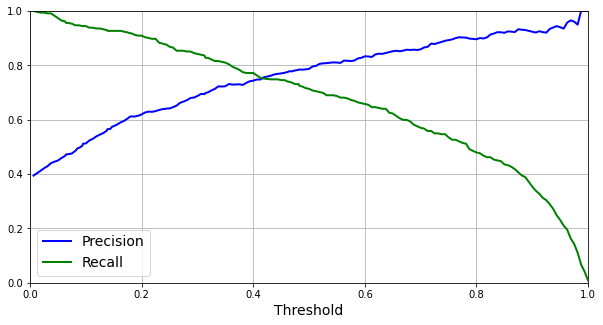

In [56]:
fig = plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions[:-1], 'b-', label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label="Recall", linewidth=2)
plt.legend(loc='lower left', fontsize=14)
plt.xlabel("Threshold", fontsize=14)
plt.grid(True)
plt.axis([0.0, 1.0, 0.0, 1.0])

plt.show()

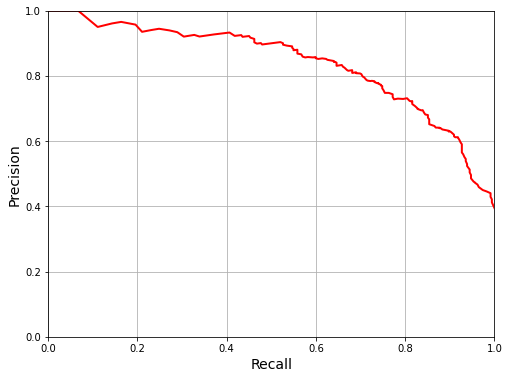

In [57]:
fig = plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, 'r-', linewidth=2)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.axis([0, 1, 0, 1])
plt.grid(True)

plt.show()

Receiver operating characteristic

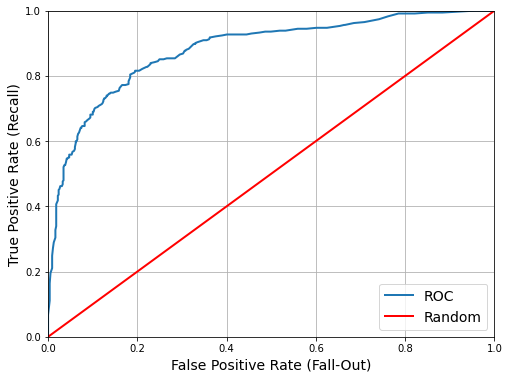

In [58]:
fpr, tpr, thresholds = roc_curve(y_full, y_scores)

fig = plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label="ROC")
plt.plot([0, 1], [0, 1], 'r-', linewidth=2, label="Random")
plt.legend(loc='lower right', fontsize=14)
plt.axis([0., 1., 0., 1.])
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.grid(True)

plt.show()

In [59]:
auc = roc_auc_score(y_full, y_scores)
print("ROC Area under curve:", auc)

ROC Area under curve: 0.8811049329456002


#### Test predictions

In [60]:
model = Model.get(X_full_encoded, y_full)
predictions = model.predict(X_test_encoded)

In [61]:
output = pd.DataFrame({'PassengerId': test_full.index,
                       'Survived': predictions})
output.to_csv('submission.csv', index=False)